# ChromProcess Introduction Part 1

ChromProcess is a library of code structures and functions which can be assembled together to create data analysis pipelines. 

## Source Files

### Experiment-specific files

Experimental data and 'metadata' (primary data), go in the front of the analysis pipeline. Files containing information about the experiment should not be altered during analysis. Primary data files consist of several chromatographic data files (as of writing ChromProcess can load `.cdf`, `.txt` or `.csv` format) and a conditions file (`.toml` format, `.csv` format is possible but deprecated). The chromatographic data files should be named in such a way that they can be sorted programatically. For example, the sequence `chrom_001.csv`, `chrom_002.csv`, `chrom_003.csv` would be appropriate.

Keeping track of the operations performed on the primary data is an important component of a reproducible pipeline. To record and input details of analysis operations, an analysis details file (e.g. `analysis_details.toml`) is also included alongside the primary data. The structure and contents of an example analysis file are shown below.

In [1]:
from pathlib import Path

analysis_file = "example_data/Example/Analysis/example_analysis_details.toml"

text = Path(analysis_file).read_text()
    
print(text)

# A code name for the data.
Dataset = "example_dataset_name"

[Method_information]
# Information on the chromatographic method used.
Method = "GCMS"
Instrument = "GCv Agilent/JEOL"
Instrument_method = "Method 5"
Calibration_model = "quadratic"
Calibration_file = "2020_03_16_GCMS_Calibrations.csv"
Derivatisation_method = '''
Reaction samples (35 Î¼L) were flash-frozen in liquid nitrogen and freeze-dried
overnight to give dry to oily residues. To each sample was added a solution of
O-ethylhydroxylamine hydrochloride in pyridine (75 Î¼L, 20 g L^âˆ’1^). A solution
of dodecane and tetradecane (100 Î¼L, 1.6 mM each in pyridine) was then added to
each sample. The samples were then shaken at 70 Â°C for 30 minutes. After
cooling to room temperature, N,O-bis(trimethylsilyl)trifluoroacetamide (25 Î¼L)
was added to each sample. The samples were again shaken at 70 Â°C for 30
minutes. The samples were then cooled to room temperature, followed by
centrifugation (3-5 min, 10,000 rpm). The supernatants

### Experiment conditions

Also keeping track of metadata is important. You can choose to do this however you wish. Below experiment metadata are stored in a `.toml` file to be compact for demonstration purposes. However, large data sets are better handled using `.csv` files.

In [2]:
from pathlib import Path

conditions_file = "example_data/Example/ExperimentalData/example_conditions.toml"
text = Path(conditions_file).read_text()
    
print(text)

# A code for the data set
dataset = "example_dataset_name"
# Values of the series covered by the chromatograms
series_values = [10.0, 20.0, 30.0]
# Chromatogram filenames in the same order as series_values
chromatograms = ["chrom_001.csv", "chrom_002.csv", "chrom_003.csv"]
# Unit for the chromatogram series.
series_unit = "time/ s"

[conditions]
dihydroxyacetone = [2.0, "M"]
formaldehyde = [2.0, "M"]
NaOH = [0.12, "M"]
CaCl2 = [0.06, "M"]
water = [0.0, "M"]




## Files applicable to several experiments

Calibration information for an instrument may be applicable to one or more sets of data. This information can therefore be stored separately from the primary data. Alternatively, a copy of a calibration file can be included within the directory of each experiment. This method has the benefit of providing a more unambiguous association of the data to the calibration. On the other hand, if changes must be made to a calibration file (e.g. adding a new calibration for a compound), multiple files must be updated which may be more labour-intensive and error-prone. Either way, creating a file which assigns each experiment to a calibration file (including paths to each file) is beneficial, as is creating a workflow for updating analyses in response to changes to the source files.

# Overview of an Example Analysis Pipeline

The first step is to create peak table files containing peak positions, boundaries and integrals for each chromatogram. Each chromatogram is loaded in as a `Chromatogram` object. The analysis and conditions files are also loaded as `Analysis_Information` and `Experiment_Conditions` objects, respectively. Information in the analysis file is used to find peaks in each chromatogram before each peak is integrated. The `Chromatogram` can then be used to create a peak table with associated condition information, if required.

Before beginning the analysis, the chromatograms should be inspected and information should be input into the analysis file as appropriate (regions, concentrations, etc.). First, the source files are directly converted into objects:

In [3]:
import os
from ChromProcess.Loading import chrom_from_csv

chromatogram_directory = 'example_data/Example/ExperimentalData/ExampleChromatograms'
chromatogram_files = os.listdir(chromatogram_directory)
chromatogram_files.sort()
chroms = []
for f in chromatogram_files:
    if f.endswith(".csv") and "chrom" in f:
        chroms.append(chrom_from_csv(f"{chromatogram_directory}/{f}"))

Before proceeding with the analysis, the chromatograms are inspected for quality (up to you as a scientist!) and for regions to be selected for peak picking. The plots can be generated by any plotting method that you are comfortable with. Below is an example using `matplotlib`.

When picking regions for peak picking, the idea is to select regions in the chromatogram in which the peaks have similar intensities. An arbitrary number of boundaries can be input. At one extreme, a single boundary for the beginning and end of the chromatogram can be use. At the other logical extreme, boundaries for individual peaks can be input. Bear in mind that the current implementation of peak picking does not account for retention time drift between chromatograms, and the regions passed to each chromatogram are the same. Therefore, 'manual' peak picking in the manner may not be accurate.

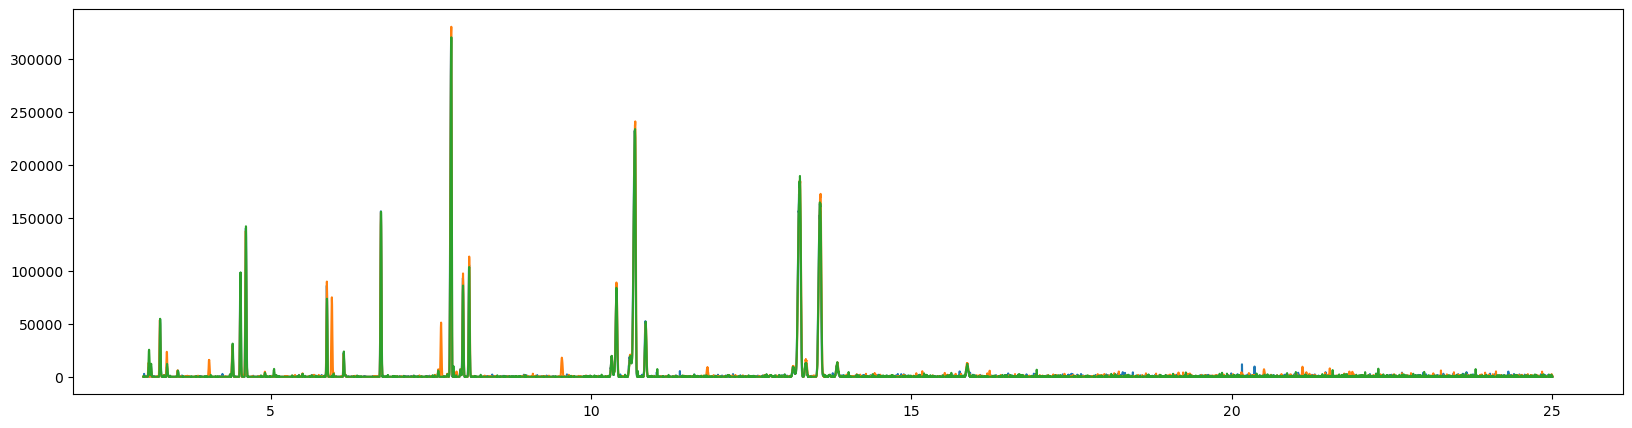

In [4]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize = (20,5))
for c in chroms:
    ax.plot(c.time, c.signal, label = c.filename)
plt.show()

In [5]:
import tomli

conditions_file = "example_data/Example/ExperimentalData/example_conditions.toml"
analysis_file = "example_data/Example/Analysis/example_analysis_details.toml"
conditions = tomli.loads(Path(conditions_file).read_text())
analysis = tomli.loads(Path(analysis_file).read_text())

Next, a peak for the internal standard is picked using information in `analysis` (the function modifies the chromatogram object passed to it by inserting the internal standard information, currently, only one internal standard is supported). This step assumes that the internal standard selected in the chromatograms is a single peak, with no peaks originating from the sample overlapping it (within the `analysis.internal_standard_region`).

In [6]:
from ChromProcess.Processing import find_peaks_in_region

is_start = analysis["Internal_standard_region"]["internal_standard_1"][0]
is_end = analysis["Internal_standard_region"]["internal_standard_1"][1]
for chrom in chroms:
    peaks = find_peaks_in_region(
                chrom, 
                is_start,
                is_end,
                smooth_width = 10,
                threshold = 0.1,
                wlen = 20
            )
    chrom.set_internal_standard(max(peaks, key = lambda x: x.height))

Information from `analysis` (originating in the analysis information file described above) is again used to pick peaks in defined regions of each chromatogram. The functions add peak information into chromatograms.

In [7]:
threshold = analysis["Peak_picking_options"]["Peak_pick_threshold"]
regions = analysis["Chromatogram_Regions"]

for chrom in chroms:
    for reg in regions:
            peaks = find_peaks_in_region(
                chrom, 
                regions[reg][0], 
                regions[reg][1], 
                smooth_width = 10,
                threshold = threshold,
                wlen=10,
                distance=10
            )
            chrom.add_peaks(peaks)

Inspecting peak picking:

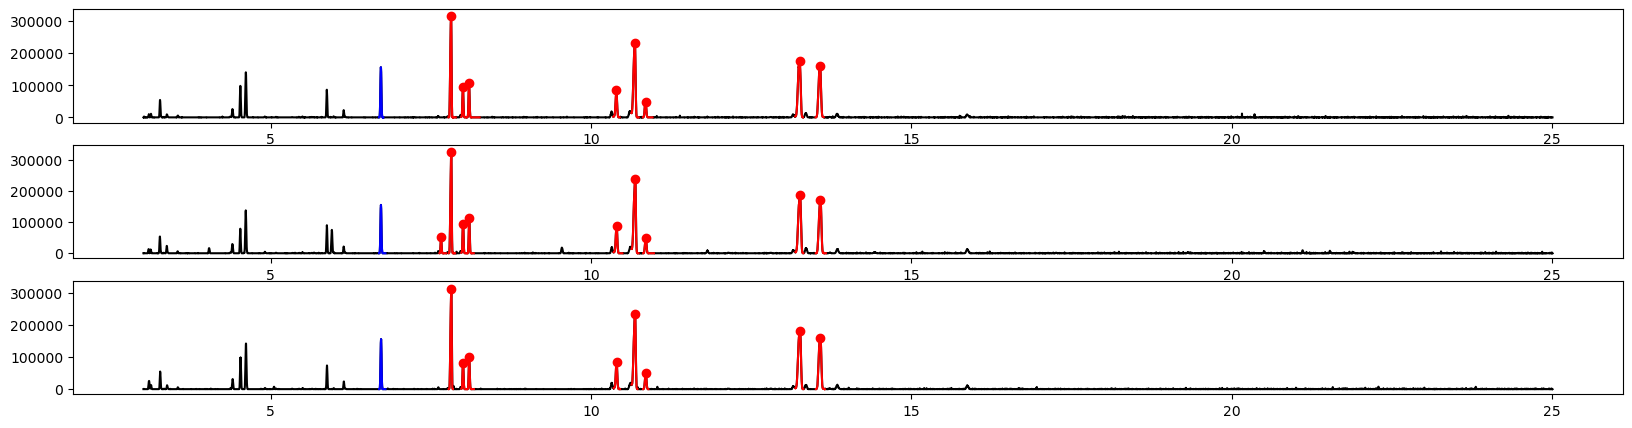

In [16]:
fig, axes = plt.subplots(nrows = len(chroms), figsize = (20,5))
for ax, chrom in zip(axes, chroms):
    time = chrom.time
    signal = chrom.signal
    ax.plot(time, signal, c = 'k', zorder = 0)
    
    # Plot internal standard
    is_peak = chrom.internal_standard
    is_idx = is_peak.indices
    ax.plot(time[is_idx], signal[is_idx], c = "b")

    # Plot picked peaks
    for c,pk in enumerate(chrom.peaks):
        peak = chrom.peaks[pk]
        idx = peak.indices
        ax.plot(time[idx], signal[idx], c= 'r', zorder  = 1)
        ax.scatter(peak.retention_time, peak.height, c= 'r', zorder  = 1)
plt.show()

The peaks picked in each chromatogram can be converted to Pandas DataFrame objects for further analysis:

In [9]:
from ChromProcess.Writers import chrom_to_df

tables = [chrom_to_df(c) for c in chroms]

tables[0].head()

,filename,retention_time,integral,height,start,end,is_retention_time,is_integral,deconvoluted
0,chrom_001.csv,7.813500,7375.790668,315311.188750,7.773625,7.888292,6.720083,2919.621001,False
1,chrom_001.csv,7.999625,1775.619826,93307.027408,7.974708,8.047833,6.720083,2919.621001,False
2,chrom_001.csv,8.096000,2056.209856,105636.424117,8.062792,8.260500,6.720083,2919.621001,False
3,chrom_001.csv,10.395833,2438.641184,85395.679287,10.349292,10.447333,6.720083,2919.621001,False
4,chrom_001.csv,10.681625,8939.897195,232477.071506,10.630125,10.744792,6.720083,2919.621001,False


If you have a series of chromatograms, it may be useful to create a DataFrame containing all of the peak information alongside the variables (e.g. time) of the series.

In [10]:
import numpy as np
import pandas as pd

file_to_time = {fname: time for fname, time in zip(conditions["chromatograms"], conditions["series_values"])}

for table in tables:
    time = file_to_time[table.filename.iloc[0]]
    table["time"] = np.full(len(table.retention_time), time)

series_table = pd.concat(tables, axis=0)
print(series_table.head())
print(series_table.tail())

        filename  retention_time     integral         height      start  \
0  chrom_001.csv        7.813500  7375.790668  315311.188750   7.773625   
1  chrom_001.csv        7.999625  1775.619826   93307.027408   7.974708   
2  chrom_001.csv        8.096000  2056.209856  105636.424117   8.062792   
3  chrom_001.csv       10.395833  2438.641184   85395.679287  10.349292   
4  chrom_001.csv       10.681625  8939.897195  232477.071506  10.630125   

         end  is_retention_time  is_integral  deconvoluted  time  
0   7.888292           6.720083  2919.621001         False  10.0  
1   8.047833           6.720083  2919.621001         False  10.0  
2   8.260500           6.720083  2919.621001         False  10.0  
3  10.447333           6.720083  2919.621001         False  10.0  
4  10.744792           6.720083  2919.621001         False  10.0  
        filename  retention_time     integral         height      start  \
3  chrom_003.csv       10.397125  2469.148876   83281.241785  10.352292 

In [11]:
fname = r"example_data/Example/ExperimentalData/ExamplePeakCollections/series_peak_table.csv"
series_table.to_csv(fname, index=False)

See part 2 for an example of how to analyse peak tables.

Footnote: it is also possible to skip the pandas code and create spreadsheet output directly from chromatograms.

In [12]:
from ChromProcess.Writers import chrom_to_peak_table_text

In [13]:
output_string = chrom_to_peak_table_text(chroms[0])